In this post, we will return to the topic of stable diffusion and discuss the [Denoising Diffusion Probabilitic Models](https://arxiv.org/abs/2006.11239) (DPPM) paper.

To get some background on stable diffusion, it's probably good to have read an earlier post in which some general concepts are [described](https://lucasvw.github.io/posts/06_stable_diffusion_basics/)

## Diffusion process

The diffusion process can be visualized with the diagram below. In this diagram $x_0$ represents a clean image (without any noise) and $x_T$ represents an image that is pure noise. So the variable $x$ represents a high dimensional tensor where the amount of dimensions is equal to the amount of pixels.

In between these, we see a number of intermediate states $x_t$ which represent images that are a mix of the clean and the pure noise image. We can transition from state to state with $p_\theta$ and $q$. 

More precisely, $q$ represents the *forward* diffusion process. With $q$ we can *move to the left*, i.e. we can move from images with less noise to images with more noise. Note that $q$'s full representation $q(x_t|x_{t-1})$ shows that it's a *probability distribution*, it's not a deterministic function that always returns a fixed image $x_t$ for the same $x_{t-1}$. Instead it defines a probability distribution over all images $x_t$. 

![Diffusion processs](diffusion_process.png){width=600}

Similarly, we have a probability distribution $p_\theta(x_{t-1}|x_t)$ which we can use to *move to the right*. From an image with some noise, we create (sample!) an image that has less noise. This is called the reverse process.

The principle of stable diffusion is to be able to do the reverse process: starting with pure noise, step by step remove the noise to end up with an image that is part of the data distribution, i.e. clean images.

## Noise and the forward process

The forward process is very straight forward, we simply take the image $x_{t-1}$ and add some noise to it. Which is nothing more than some random values, for example sampled from a *standard normal distribution*, a normal distribution with a mean of 0 and a standard deviation of 1:

In [ ]:
#| code-fold: true
import random
from itertools import zip_longest
from functools import reduce, partial
from pathlib import Path
from urllib.request import urlretrieve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torcheval.metrics as tem
import fastcore.all as fc
from PIL import Image
import torchvision
import fastcore.all as fc
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray_r'

# pip install --upgrade transformers
# pip install --upgrade diffusers[torch]
from diffusers import UNet2DModel

from nntrain.dataloaders import DataLoaders
from nntrain.learner import *
from nntrain.activations import *
from nntrain.acceleration import *
from nntrain.rnn import *

In [ ]:
#| code-fold: true

# Code taken from to help with plotting:
# https://github.com/fastai/course22p2/blob/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/05_datasets.ipynb

def subplots(
    nrows=1, # Number of rows in returned axes grid
    ncols=1, # Number of columns in returned axes grid
    figsize=None, # Width, height in inches of the returned figure
    imsize=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

def get_grid(
    n, # Number of axes
    nrows=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols=None, # Number of columns, defaulting to `ceil(n/rows)`
    title=None, # If passed, title set to the figure
    weight='bold', # Title font weight
    size=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

def show_images(ims, # Images to show
                nrows=None, # Number of rows in grid
                ncols=None, # Number of columns in grid (auto-calculated if None)
                titles=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

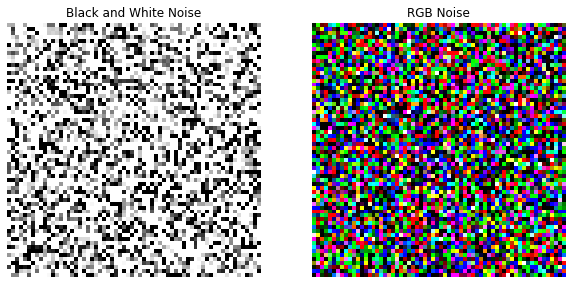

In [ ]:
bw_noise  = torch.randn(64, 64)      # 1 channel: Black and white
rgb_noise = torch.randn(64, 64, 3)   # 3 channels: RGB

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(bw_noise.clip(0,1));
axs[1].imshow(rgb_noise.clip(0,1));
axs[0].set_title("Black and White Noise")
axs[1].set_title("RGB Noise")
axs[0].axis('off');
axs[1].axis('off');

Let's see what happens when we iteratively add more and more noise to an image:

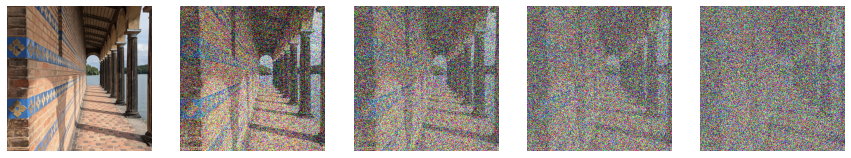

In [ ]:
im = Image.open('./image.png')
im = (torchvision.transforms.functional.pil_to_tensor(im) / 255.0).permute(1,2,0)
shape = im.shape

plots = 5
fig, axs = plt.subplots(1, plots, figsize=(15,10));
axs[0].imshow(im);
axs[0].axis('off');
for i in range(1,plots):
    noise = torch.randn(shape) * 0.5
    im = (im + noise).clip(0,1)
    axs[i].imshow(im);
    axs[i].axis('off')

On the left, we start with a clean image, and gradually add more and more noise to it. Diffusion based models are defined  as models in which the forward (or diffusion, noising) process is fixed to *a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule*. A Markov chain (or process) is simply a (stochastic) process with a fixed number of states and transition probabilities that only depend on the current state, and are therefore *memoryless*. This forward process is defined as:

$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t I)
$$

Let's parse this:

We see that indeed the forward process is memoryless, since the probability distribution over $x_t$ only depends on $x_{t-1}$ and not any earlier state. The probability distribution in question is a normal distribution centered around $\mu = \sqrt{1-\beta_t}x_{t-1}$ with a variance of $\beta_t I$. With $\beta_t$ (the variance schedule) being a constant that only depends on $t$ and the identity matrix $I$ reflecting that there is no dependency (for the random component) between the different pixels. The authors in the paper run experiments with $T=1000$ (fixed number of states: the second condition that makes this a Markov chain) and a fixed variance schedule running from $\beta_1 = 10^{-4}$ to $\beta_T = 0.02$. Let's define this in code:

In [ ]:
T = 1000
beta = torch.linspace(1e-4, 1e-2, T)

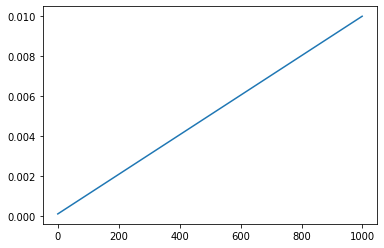

In [ ]:
plt.plot(beta);

So we have a linear variance schedule, starting on the left with T=1 and a very small value for $\beta$ and then increasing linearly to larger values.

Furthermore, we can re-write the forward process in a way that allows to express $q$ in terms of the clean image $x_0$:

$$
q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar\alpha_t}x_0, (1-\bar\alpha_t)I)
$$

where $\alpha_t = 1-\beta_t$ and $\bar\alpha_t = \prod_{s=1}^t \alpha_s$. This allows to immediately compute some intermediate image $x_t$ from the clean image $x_0$, without doing all the intermediate steps. Let's also put this into code:

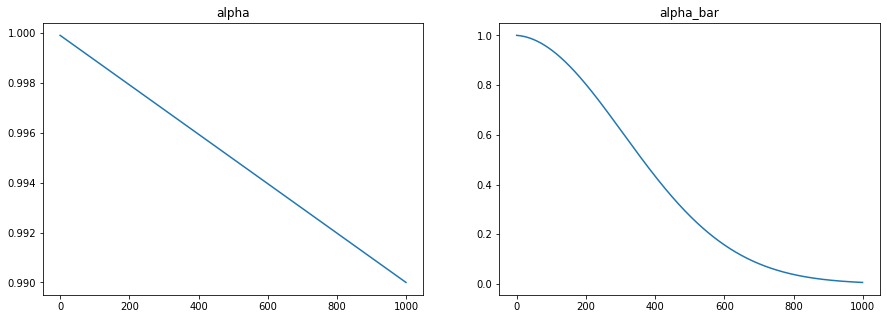

In [ ]:
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(alpha);
axs[0].set_title('alpha');
axs[1].plot(alpha_bar);
axs[1].set_title('alpha_bar');

From the figure on the right for $\bar\alpha_t$, we see an interesting property: the value for $t=1$ is almost 1, and the last value ($t=999$) goes towards 0. Plugging these values into the normal distribution above, we see that $x_1$ is centered almost exactly at $x_0$ and has very little noise, whereas $x_{999}$ is centered around 0 and has (almost) unit variance noise. We thus indeed diffuse from a clean image into an image consisting purely of (standard normal) noise.

To understand how we can create (samples from) the forward process, we have to understand how we can create samples from the normal distribution defined above. For that purpose it's intructive to review some basic arithmetic rules around random variables. Let's say $X = \mathcal{N}(0,1)$ and $Y = 5X + 3$, then $Y$ is also going to be normally distributed, but the mean and variance will have shifted, let's see how:

\begin{align}
\mathbb{E}[Y] &= \mathbb{E}[5X + 3] \\
              &= 5\mathbb{E}[X] + 3 \\
              &= 5\cdot0 + 3 \\
              &= 3
\end{align}

And for the variance:

\begin{align}
\mathrm{Var}[Y] &= \mathrm{Var}[5X + 3] \\
                &= 5^2 * \mathrm{Var}[X] \\
                &= 25
\end{align}

Then, to get a normal distribition: $\mathcal{N}(x_t; \sqrt{\bar\alpha_t}x_0, (1-\bar\alpha_t)I)$, we can thus sample from a standard normal distribution and simply add the mean: $\sqrt{\bar\alpha_t}x_0$ ($x_0$ being the clean image) and multiply by: $\sqrt{1-\bar\alpha_t}$ (note the usage of the square root to cancel out the squaring of the constant). Let's do this in code:

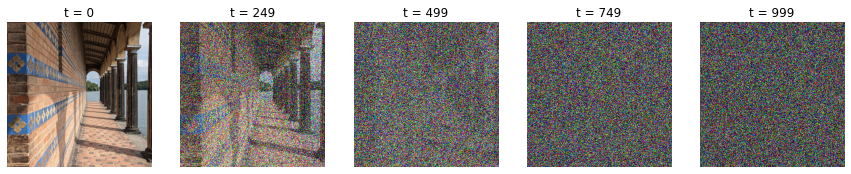

In [ ]:
im = Image.open('./image.png')
im = (torchvision.transforms.functional.pil_to_tensor(im) / 255.0).permute(1,2,0)

plots = 5
fig, axs = plt.subplots(1, plots, figsize=(15,10));
axs[0].imshow(im);
axs[0].axis('off');

ts = np.linspace(0, T-1, plots)
for i in range(0,plots):
    t = int(ts[i])
    alpha_bar_t = alpha_bar[t]
    # take a sample from N(0,1)
    noise = torch.randn(shape)
    # move the sample to the specified mean and variance
    im = (np.sqrt(alpha_bar_t)*im + np.sqrt((1-alpha_bar_t))*noise).clip(0,1)
    axs[i].imshow(im);
    axs[i].axis('off')
    axs[i].set_title(f't = {t}')

These images are actual samples from the forward diffusion process as specified by the DDPM paper. Note that already from t=499 onward it's practically impossible to see what the clean image was depicting. We will see this again later on.

## Reverse process

Now that we have a good understanding of the concepts, the notation and the forward process, it's time to start discussing the reverse process. This is what we are actually interested in, since it allows us to generate images from pure noise! But before we do, just take a moment to realize how difficult this actually is. Imagine the very high dimensional pixel space, where each pixel is a separate dimension. For a 128 by 128 image (a small image), that is more than 16000 dimensions. Any position in this space represents an image, but if we randomly select any position in this space the chances are *extremely* small that we will pick an image that depicts anything different from noise. This means that the data distribution is very small in comparison to this space, and to return from any random point to this data distribution is not trivial.

In the paper, the reverse process is described as follows:

$$
p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

So to take one step *to the right* we need to sample from a distribution with mean $\mu_\theta$ and variance $\Sigma_\theta$. These two expressions are unknown, and thus will have to be learned by a neural network (as represented by the $\theta$ subscript). One decision that is made in the paper is to not learn the $\Sigma_\theta$ network because it leads to unstable training and poorer sample quality. Instead it's set to a time dependant constant: $\sigma_t^2 = \beta_t$ or $\sigma_t^2 = \tilde\beta_t = \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t}\beta_t$.

In the paper it is shown by using lots of complicated mathematics including maximum likelihood estimation, variational inference,  evidence lower bound, KL divergence and reparametrizations, that a simplified loss function can be written as:

\begin{align}
L_\mathrm{simple}(\theta) = \mathbb{E}_{t,x_0,\epsilon}{ \left[ \| \epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t) \|^2 \right] } 
\end{align}


Which is arguably still quite a complex expression, so let's digest it step by step. 

On the left we have a loss function $L_{\textrm{simple}}$ which is parametrized by $\theta$. This denotes that it's a function of all the parameters $\theta$ of some neural network. In other words, we want to minimize the loss function by tweaking the parameters $\theta$ in the neural network. 

On the right side of the equation we have an expected value symbol $\mathbb{E}[.]\$, which we recognize to be similar to $\mathbb{E} \left( \epsilon - \bar\epsilon \right)^2$ being the Mean Squared Error (MSE) of the estimator $\bar\epsilon$ of parameter $\epsilon$. The parameter $\epsilon$ is defined in the paper to be the noise, and is simply sampled from a standard normal distribution. 

The $\epsilon_{\theta}$ parameter represents a neural network (parametrised by $\theta$) estimating the noise ($\epsilon$). This network has two inputs: $\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon$ and $t$. This first expression is simply a sampled noisy image originating from applying the forward process on some clean image $x_0$ to timestep $t$:

\begin{align}
\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon &= \sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t} \mathcal{N}(\epsilon;0,I)\\
&= \sqrt{\bar\alpha_t} x_0 + \mathcal{N}(0,(1-\bar\alpha_t)I) \\
&= \mathcal{N}(\sqrt{\bar\alpha_t} x_0,(1-\bar\alpha_t)I) \\
&= q(x_t|x_0)
\end{align}

To summarize: $\epsilon_{\theta}$ represents a neural network which learns to predict the noise from noisy images. We can create training data by using the formula for the forward process, and we will use an MSE loss on the predictions and the actual noise.

It's also instructive to compare this to the pseudo-code describing the training of the neural network in the DDPM paper:

![pseudo code for training](training.png){width=400}

On the second line we simply take a clean image $x_0$. Next, we randomly select a value for $t$. Then we sample some noise from a standard normal distribution. On line 5, we do the forward pass on the noisy image, compute the MSE loss on the prediction and the actual loss, compute the backward pass and finally update the weights of our network.

## Training: preparing the data

Let's use the same data we have been using before: fashion-mnist:

In [ ]:
#| code-fold: true
from datasets import load_dataset,load_dataset_builder

from nntrain.dataloaders import DataLoaders, hf_ds_collate_fn
from nntrain.learner import *
from nntrain.activations import *

import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.nn.functional as F
from operator import attrgetter
from functools import partial
import fastcore.all as fc
import math
import torcheval.metrics as tem
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
hf_dd = load_dataset(name)

# Transform the images to 32x32 (from 28x28) so that the
# convolutional arithmetic in the UNet works
def transformi(b): 
    b['image'] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b['image']]
    return b

hf_dd = hf_dd.with_transform(transformi)

Reusing dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

Parameter 'transform'=<function transformi> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


[Previously](https://lucasvw.github.io/posts/09_nntrain_ds/) we created a custom collate function to pull the data out of the Huggingface `DatasetDict` object and put it in a tuple. For the purpose of a diffusion model, we need to change this collation function to make sure the DataLoader will return samples consisting of the noisy image $q(x_t|x_0)$, the sampled timestep $t$ and the noise $\epsilon$. The noisy image and timestep $t$ will be inserted into the model, and the noise $\epsilon$ will be used as target for the MSE loss function.

To do this, let's create a noisify function that returns everything we need:

In [ ]:
def noisify(clean_images):
    N = clean_images.shape[0]
    t = torch.randint(low=0,high=T,size=(N,))
    alpha_bar_t = alpha_bar[t, None, None, None] # add empty dimensions for broadcasting
    noise = torch.randn(clean_images.shape)
    # According to the forward process in the paper:
    noised_images = (alpha_bar_t.sqrt()*clean_images + (1-alpha_bar_t).sqrt()*noise)
    return noised_images, t, noise

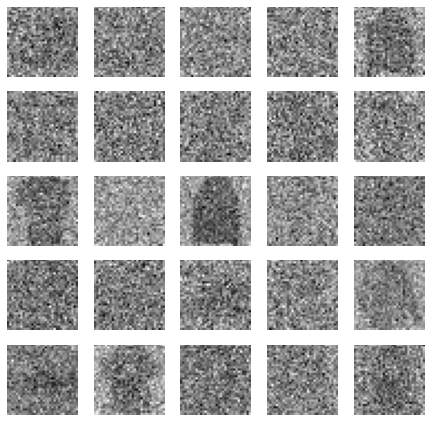

In [ ]:
bs = 128

def collate_ddpm(b):
    image, label = hf_ds_collate_fn(b, flatten=False)
    return noisify(image)

dls = DataLoaders.from_hf_dd(hf_dd, bs, collate_fn=collate_ddpm)

it = iter(dls.train)
b = next(it)

show_images(b[0][:25], imsize=1.5)

## Training: setting up the model

Next, we are going to need a model. Remember that our model is going to take (noisy) images as input, and will also output images that represent predictions of the noise. One model that is capable of doing so, is a UNet. This model was shortly discussed in an earlier [post](https://lucasvw.github.io/posts/06_stable_diffusion_basics/#the-main-component-unet). Let's use a Unet model from the diffusers library:

In [ ]:
model = UNet2DModel(in_channels=1, 
             out_channels=1,
             block_out_channels=(16,32,64,64), 
             norm_num_groups=8)

## Training

To use this model, in combination with having 3 items in the batch (noised image, timestep $t$ and actual noise), we need to make some adjustments to our `Learner`. Specifically, we need to overwrite the `predict` method:

1. We need to pass the first two items from the batch (noised image and timestep $t$) to the model
2. The Unet model we are using, is wrapping the result of the forward pass in a dictionary (with key `sample`), we thus need to pull this value out of the dictionary.

We also need to update the `loss` method, since the targets are stored as third item in the batch:

In [ ]:
class DDPMLearner(Learner):
    def predict(self):
        self.preds = self.model(self.batch[0], self.batch[1]).sample
        
    def get_loss(self): 
        self.loss = self.loss_fn(self.preds, self.batch[2]) 

With the data, the model and the adapted training loop, we can now train as usual:

epoch,mode,loss
0,train,0.085
0,eval,0.032
1,train,0.028
1,eval,0.026
2,train,0.024
2,eval,0.023
3,train,0.023
3,eval,0.022
4,train,0.021
4,eval,0.021


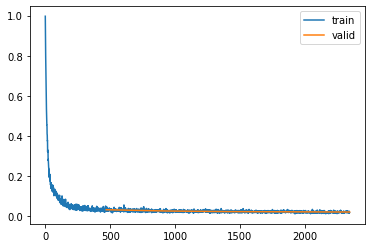

In [ ]:
# Train parameters
epochs = 5
lr     = 5e-3

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        SchedulerS(scheduler)]

l = DDPMLearner(model, dls, torch.nn.MSELoss(), torch.optim.Adam, None, subs=subs)
l.fit(epochs, lr=lr)

## Sampling

As a final step, we want to start sampling images. Starting with an image of pure noise, and by gradually denoising it, arrive at an image which is considered "clean" by the model. In the paper, the following algorithm is given:

![pseudo code for sampling](sampling.png){width=400}

On line 1, we start with a pure noise image $x_T$. Next, we iterate through the timesteps (in reverse). During each step, a prediction of the noise in the image $\epsilon_{\theta}(x_t, t)$ is made. We subtract this (scaled) prediction from the image (line 4), and add back some (scaled) random noise $z$. Let's put this into code:

In [ ]:
with torch.no_grad():
    device = next(model.parameters()).device
    sz = (9,1,32,32)
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(T)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        
        alpha_t       = alpha[t]
        alpha_bar_t   = alpha_bar[t]
        
        sigma = beta.sqrt()
        sigma_t = sigma[t]
        
        noise_prediction = l.model(x_t, t_batch).sample
        
        x_t = 1/alpha_t.sqrt()*(x_t - (1-alpha_t)/(1-alpha_bar_t).sqrt()*noise_prediction) + sigma_t*z
        
        preds.append(x_t.cpu())

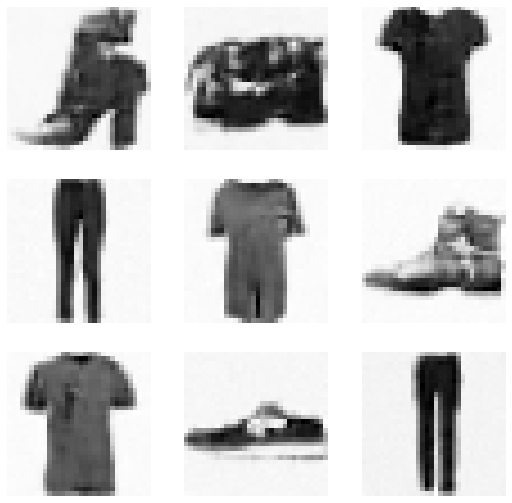

In [ ]:
show_images(preds[-1], imsize=1.5)

In [ ]:
%matplotlib auto

fig, ax = plt.subplots(figsize=(10,2))
fig.tight_layout()
ax.axis('off')

ims = []
for t, images in enumerate(preds):
    im = ax.imshow(torch.concat([i for i in images], dim=2).permute(1,2,0), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=50000)
display(HTML(ani.to_html5_video()))

writer = animation.FFMpegWriter(fps=60, metadata=dict(artist='Me'), bitrate=200)
ani.save("movie.mp4", writer=writer)

Using matplotlib backend: agg
